# MoSDeF: A Molecular Simulation and Design Framework

The Molecular Simulation and Design Framework (MoSDeF) is a collection of open-source tools ([hosted on Github](https://github.com/mosdef-hub)) aimed at facilitating the construction and simulation of complex molecular systems - with a particular focus on the automated screening of large structural parameter spaces. All tools are written as Python packages and feature a Python-based API.

## Basic mBuild tutorial

The first of the MoSDeF tools we will explore is the [mBuild package](http://mosdef-hub.github.io/mbuild/), which utilizes a hierarchical, component-based approach to molecule construction, allowing complex systems to be built using a subset of re-usable parts, just like playing with Legos! In this tutorial we will explore some of mBuild's basic functionality by constructing a linear alkane chain. We'll then examine how mBuild's component-based design approach allows components to be easily swapped to facilitate structural screening.

### Hierarchical design approach

mBuild uses a [composite design pattern](https://en.wikipedia.org/wiki/Composite_pattern) to approach the creation of complex molecular systems. This yields the following features:
* Molecules feature a tree-like hierarchy (as shown in the figure below)
* All components in the hierarchy feature a common data structure (an mBuild `Compound`)
* The lowest level of the hierarchy (the 'leaves') are referred to as `Particles` and are typically individual atoms
* Atomic positions are maintained only at the `Particle` level; higher level components can compute properties based on contained `Particles`

Below is an example of an mBuild molecule hierarchy for an alkylsilane monolayer attached to a crystalline silica surface.
<img src="hierarchical_design_image.png" alt="Drawing" style="width: 700px;"/>

### Importing mBuild

To begin using mBuild we need to import the mBuild package, which is available through both the [Anaconda](https://anaconda.org/mosdef/mbuild) and [pip](https://pypi.python.org/pypi/mbuild/0.7.2) package managers. mBuild can also be downloaded from source, which is hosted on [Github](https://github.com/mosdef-hub/mbuild).

Here, we'll import the mBuild package along with a `visualize` routine that will allow us to view our molecules along the way. The `%matplotlib notebook` routine is a Jupyter 'magic' command that allows us to interactively view matplotlib figures within a notebook.

In [2]:
%matplotlib notebook
from visualize import visualize
import mbuild as mb

### The `Compound` class

The base class of mBuild is the `Compound` class, which defines the primary building block used for constructing molecules. Molecules are constructed hierarchically; however, each level of the hierarchy inherits from the `Compound` class. This means that `Compounds` may contain other `Compounds`, and that the same methods and attributes are present for molecule components at any level of the hierarchy.

In [ ]:
my_compound = mb.Compound()
type(my_compound)

mBuild `Compounds` feature [a variety of useful methods and attributes](http://mosdef-hub.github.io/mbuild/data_structures.html) to facilitate system construction.

In [ ]:
dir(my_compound)

### Creating `Compounds`

There are several ways that `Compounds` can be created with mBuild. The simplest is to construct them from `Particles`. The `Particle` class is used to define `Compounds` residing at the lowest level of the containment hierarchy. Standard mBuild protocol is to define `Particle` names according to their elemental symbol (e.g. `'C'`), or to preface `Particle` names by an underscore for coarse-grained beads (e.g. `'_CH4'`). This aids in the atomtyping and forcefield application process which we will get back to later.

Now, lets just create a simple carbon `Particle`. [Several arguments are available](http://mosdef-hub.github.io/mbuild/data_structures.html#mbuild.compound.Compound) to set various `Compound`/`Particle` attributes upon instantiation. Here, we'll use the `name` argument to specify the element of our `Particle` and the `pos` argument to specify the location of the `Particle` in Cartesian space.

**Note:** mBuild expects all distance units to be in nanometers.

In [4]:
carbon = mb.Particle(name='C', pos=[1.0, 2.0, 3.0])
carbon

<C pos=( 1.0000, 2.0000, 3.0000), 0 bonds, id: 4537642176>

Individual atoms are boring. Let's try now to create a simple CH2 moiety. (Don't worry about the undercoordinated carbon; we'll be using this later to piece together an alkane chain.)

The first step we need to take is to create an empty mBuild `Compound` to add our `Particles` to (we can give this `Compound` a name if we'd like).

In [ ]:
ch2 = mb.Compound()
ch2 = mb.Compound(name='CH2')

Now we need to create three `Particles`: one carbon and two hydrogens. We'll manually set the atomic positions such that they represent realistic atomic spacings.

In [ ]:
carbon = mb.Particle(pos=[0.0, 0.0, 0.0], name='C')
hydrogen = mb.Particle(pos=[0.109, 0.0, 0.0], name='H')
hydrogen2 = mb.Particle(pos=[-0.109, 0.0, 0.0], name='H')

As described early, the hierarchical design approach used by mBuild allows `Compounds` to contain other `Compounds`. To add our three `Particles` to the hierarchy of our CH2 `Compound` we can use the `add` function. All we need to provide are the variable references to these three particles in a list-like format.

In [ ]:
ch2.add([carbon, hydrogen, hydrogen2])

We can use the `particles()` method to view the `Particles` contained by a `Compound`. This method is written as a generator to conserve memory for large systems, so we'll need to convert to a `list`.

In [ ]:
list(ch2.particles())

As we can see, our carbon `Particle` and two hydrogen `Particles` are now contained within our CH2 `Compound`. Now let's visualize our `Compound` to confirm we built this correctly.

**Note:** For the purposes of this tutorial we are using a local `visualize` routine that utilizes `matplotlib` to view our molecules. mBuild also contains a `Compound.visualize()` routine that uses the `NGLview` package for molecule visualization; however, this routine is currently under construction.

In [ ]:
visualize(ch2)

Looking good! However, although we've added our three `Particles` to the CH2 `Compound`, we have yet to define any bonds between them. To accomplish this, we can use the `Compound.add_bond()` method to specify our two C-H bonds.

In [ ]:
ch2.add_bond((carbon, hydrogen))
ch2.add_bond((carbon, hydrogen2))
visualize(ch2)

Visually we now see that our CH2 `Compuound` contains three `Particles` and two C-H bonds. We can also use the `Compound.bonds()` method to confirm that our bonds were added correctly.

In [ ]:
list(ch2.bonds())

### Reusing components

It would be quite tedious to have to go through each of the above steps every time we wanted to create a new CH2 `Compound`. However, this problem is easily solved by wrapping this routines together into a class.

Here, we'll create a class for our CH2 moiety using the same approach we just took above, so that we can easily reuse this piece when constructing more complex molecules.

In [ ]:
class CH2(mb.Compound):
    def __init__(self):
        super(CH2, self).__init__()
        
        carbon = mb.Particle(pos=[0.0, 0.0, 0.0], name='C')
        hydrogen = mb.Particle(pos=[0.109, 0.0, 0.0], name='H')
        hydrogen2 = mb.Particle(pos=[-0.109, 0.0, 0.0], name='H')
        self.add([carbon, hydrogen, hydrogen2])
        self.add_bond((carbon, hydrogen))
        self.add_bond((carbon, hydrogen2))

As we can see, our class definition contains the same commands we just used to the create the CH2 `Compound` above; however, we have replaced `ch2` with `self` so that these commands will be performed on any instance of our `CH2` class. Additionally, since we want our class instance to be an mBuild `Compound` we specify that our `CH2` class should inherit from `mb.Compound`.

Now lets try instantiating our class.

In [5]:
ch2 = CH2()
ch2.name = 'myCH2'
ch2.name
visualize(ch2)

NameError: name 'CH2' is not defined

While there are instances where creating `Compounds` particle-by-particle is useful, this process can get a bit tedious. It's much easier to create them by loading in pre-assembled building blocks. These can easily be created using software such as [Avogadro](https://avogadro.cc/). The `load()` function can create mBuild `Compounds` from a variety of common file formats (e.g. PDB, MOL2). Here, we'll create the same CH2 `Compound` by loading from a PDB file.

In [ ]:
ch2 = mb.load('ch2.pdb')
visualize(ch2)

We can also wrap this into a class if we want.

<IPython.core.display.Javascript object>


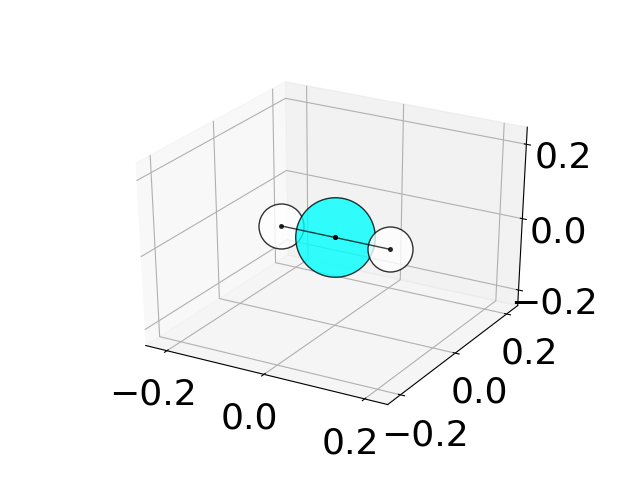

In [7]:
class CH2(mb.Compound):
    def __init__(self):
        super(CH2, self).__init__()
        
        mb.load('ch2.pdb', compound=self)
        
ch2 = CH2()
visualize(ch2)

### Connecting components

We've already found that `Particles` can be connected (i.e. bonded) by using the `add_bond` routine; however, this does not actually move the atoms in space, and it would become burdensome to need to manually update the position of each atom. This is where [mBuild's `Port` class](http://mosdef-hub.github.io/mbuild/data_structures.html#mbuild.port.Port) comes into play. `Ports` in the most general sense define a location in space; however, in most cases these can be thought of as dangling bonds.

Let's test this functionality by adding a `Port` to the carbon atom of CH2. First, we'll instantiate our CH2 class and use the `particles_by_name` method to locate the carbon `Particle` within the `Compound`.

In [9]:
ch2 = CH2()
carbon = list(ch2.particles_by_name('C'))[0]
carbon

<C pos=( 0.0000, 0.0000, 0.0000), 0 bonds, id: 4580520456>

Now we'll instantiate the `Port` class. We can attach the `Port` to the carbon atom by using the `anchor` attribute. This allows mBuild to know which atoms to creating bonds between when two `Ports` are connected. We can also provide an `orientatio`n vector to give our `Port` a desired direction, and can use the `separation` argument to shift our `Port` from the position of the anchor `Particle`. Since we're going to be connecting to another CH2 when building an alkane, we will shift our `Port` roughly half of a C-C bond length.

In [11]:
port = mb.Port(anchor=carbon, orientation=[0, 0, 1], separation=0.075)
type(port)

mbuild.port.Port

We now need to add this `Port` to the containment hierarchy of our CH2 molecule, again using the `add` method. We can also provide a descriptive label for our `Port` that we can use for easy access.

In [13]:
ch2.add(port, label='up')
type(ch2['up'])

MBuildError: Part <Port 0 particles, non-periodic, 0 bonds, id: 4580482800> already has a parent: <CH2 3 particles, non-periodic, 2 bonds, id: 4580538576>

If we visualize we'll now see that our CH2 molecule features a `Port` oriented in the positive z direction.

<IPython.core.display.Javascript object>


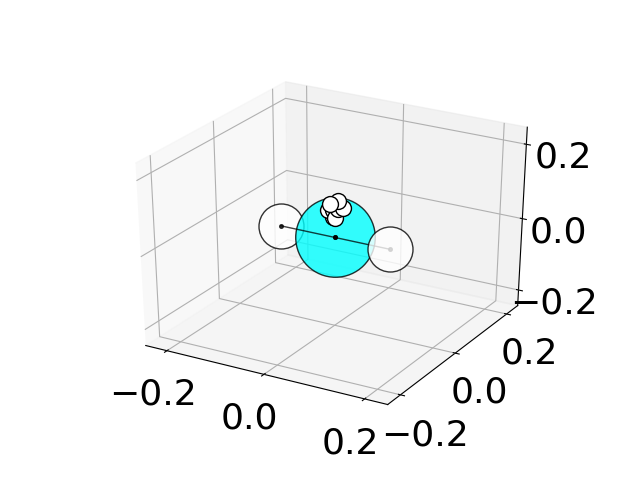

In [14]:
visualize(ch2)

The `force_overlap()` function can be used to force the overlap of two `Ports` by performing a coordinate transform on one of the two `Compounds` that should be connected. This will also create a bond between the anchor `Particles` of each `Port`. We'll explore this functionality here by connecting two CH2 groups to create a C2H4 group. Here, we'll also use mBuild's `clone()` function which returns a deep copy of a `Compound`.

In [ ]:
c2h4 = mb.Compound()
ch2_copy1 = mb.clone(ch2)
ch2_copy2 = mb.clone(ch2)
mb.force_overlap(move_this=ch2_copy1,
                 from_positions=ch2_copy1['up'],
                 to_positions=ch2_copy2['up'])
c2h4.add((ch2_copy1, ch2_copy2))
visualize(c2h4)

In [ ]:
class CH2(mb.Compound):
    def __init__(self):
        super(CH2, self).__init__()
        
        mb.load('ch2.pdb', compound=self)
        carbon = list(self.particles_by_name('C'))[0]
        up_port = mb.Port(anchor=carbon, orientation=[0, 0, 1], separation=0.075)
        down_port = mb.Port(anchor=carbon, orientation=[0, 0, -1], separation=0.075)
        self.add(up_port, label='up')
        self.add(down_port, label='down')

In [ ]:
ch2 = CH2()
visualize(ch2)

### Building a linear alkane

Now that we've defined a CH2 building block, we can use this to construct a linear alkane chain. Again we will define a class that inherits from `Compound`. We'll define a class that connects four CH2 units and caps the ends with hydrogen atoms to create a butane molecule. 

In [ ]:
class Hydrogen(mb.Compound):
    def __init__(self):
        super(Hydrogen, self).__init__()
        
        self.add(mb.Particle(name='H'))
        up_port = mb.Port(anchor=self[0], orientation=[0, 0, 1], separation=0.075)
        self.add(up_port, 'up')

In [ ]:
hydrogen = Hydrogen()
visualize(hydrogen)

In [ ]:
butane = mb.Compound()

hydrogen = Hydrogen()
last_unit = CH2()
mb.force_overlap(move_this=hydrogen,
                 from_positions=hydrogen['up'],
                 to_positions=last_unit['up'])
butane.add(last_unit, label='ch2[$]')
butane.add(hydrogen, label='up-cap')
visualize(butane)

In [ ]:
for _ in range(3):
    current_unit = CH2()
    mb.force_overlap(move_this=current_unit,
                     from_positions=current_unit['up'],
                     to_positions=last_unit['down'])
    butane.add(current_unit, label='ch2[$]')
    last_unit=current_unit

visualize(butane)

In [ ]:
hydrogen2 = Hydrogen()
mb.force_overlap(move_this=hydrogen2,
                 from_positions=hydrogen2['up'],
                 to_positions=last_unit['down'])
butane.add(hydrogen2, label='down-cap')
visualize(butane)

In [ ]:
class Butane(mb.Compound):
    def __init__(self):
        super(Butane, self).__init__()
        
        hydrogen = Hydrogen()
        last_unit = CH2()
        mb.force_overlap(move_this=hydrogen,
                         from_positions=hydrogen['up'],
                         to_positions=last_unit['up'])
        self.add(last_unit, label='ch2[$]')
        self.add(hydrogen, label='up-cap')
        for _ in range(3):
            current_unit = CH2()
            mb.force_overlap(move_this=current_unit,
                             from_positions=current_unit['up'],
                             to_positions=last_unit['down'])
            self.add(current_unit, label='ch2[$]')
            last_unit=current_unit
        hydrogen = Hydrogen()
        mb.force_overlap(move_this=hydrogen,
                         from_positions=hydrogen['up'],
                         to_positions=last_unit['down'])
        self.add(hydrogen, label='down-cap')

In [ ]:
butane = Butane()
visualize(butane)